<a href="https://colab.research.google.com/github/SianC7/LAIDS/blob/main/AE_MLP_Experiment_3_Generalisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load in pre-made datasets
(Already normalised)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Imports

In [2]:

import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns # Import seaborn for heatmap plotting
import numpy as np
import matplotlib.pyplot as plt

#Loads Datasets

In [3]:

#save_path = "/Users/siancaine/Downloads/AE_Datasets"
save_path = "/content/drive/MyDrive/Colab Notebooks/Honours Project/Sian's Models/AE-MLP files"

# Training sets
X_train = pd.read_csv(os.path.join(save_path, "AE_X_train.csv")).to_numpy()
y_train = pd.read_csv(os.path.join(save_path, "AE_y_train.csv")).to_numpy().ravel()

# Validation sets
X_val = pd.read_csv(os.path.join(save_path, "AE_X_val.csv")).to_numpy()
y_val = pd.read_csv(os.path.join(save_path, "AE_y_val.csv")).to_numpy().ravel()

# # Classifier training sets
X_classifier_train = pd.read_csv(os.path.join(save_path, "adasyn_classifier_X_train.csv")).to_numpy() # MLP training data augumented using adasyn
y_classifier_train = pd.read_csv(os.path.join(save_path, "adasyn_classifier_y_train.csv")).to_numpy().ravel()

# Classifier validation sets
X_classifier_val = pd.read_csv(os.path.join(save_path, "classifier_X_val.csv")).to_numpy()
y_classifier_val = pd.read_csv(os.path.join(save_path, "classifier_y_val.csv")).to_numpy().ravel()

# Test sets
X_test = pd.read_csv(os.path.join(save_path, "X_test.csv")).to_numpy()
y_test = pd.read_csv(os.path.join(save_path, "y_test.csv")).to_numpy().ravel()

# --- Label Encoding ---
attack_type_map = {'Normal Traffic': 0, 'Port Scanning': 1, 'Web Attacks': 2, 'Brute Force': 3, 'DDoS': 4, 'Bots': 5, 'DoS': 6} # Create a mapping from attack type to integer label



#Plot PCA graphs for visualisation

In [4]:
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# import numpy as np


# # Reduce dimensionality to 2D
# pca = PCA(n_components=2)
# X_test_pca = pca.fit_transform(X_test)

# reverse_attack_type_map = {v: k for k, v in attack_type_map.items()} # Assuming attack_type_map is defined

# # Loop over each attack type
# for attack_label, attack_name in reverse_attack_type_map.items():
#     # Mask for benign traffic
#     mask_benign = y_test == 0
#     # Mask for current attack
#     mask_attack = y_test == attack_label

#     # Plot
#     plt.figure(figsize=(6,5))
#     plt.scatter(X_test_pca[mask_benign, 0], X_test_pca[mask_benign, 1],
#                 alpha=0.3, label="Normal Traffic", color="blue")
#     plt.scatter(X_test_pca[mask_attack, 0], X_test_pca[mask_attack, 1],
#                 alpha=0.5, label=attack_name, color="red")
#     plt.title(f"PCA: {attack_name} vs Normal Traffic")
#     plt.xlabel("PC 1")
#     plt.ylabel("PC 2")
#     plt.legend()
#     plt.tight_layout()
#     plt.show()


#Remove Class Function

In [5]:
def Remove_attack_type(attack_type):

    # Similarly for classifier training sets
    mask_classifier_train = y_classifier_train != attack_type
    X_classifier_train_filtered = X_classifier_train[mask_classifier_train]
    y_classifier_train_filtered = y_classifier_train[mask_classifier_train]

    # Classifier validation sets
    mask_classifier_val = y_classifier_val != attack_type
    X_classifier_val_filtered = X_classifier_val[mask_classifier_val]
    y_classifier_val_filtered = y_classifier_val[mask_classifier_val]

    return X_classifier_train_filtered, y_classifier_train_filtered, X_classifier_val_filtered, y_classifier_val_filtered


#Import AE

In [6]:
def get_ae():
  # -------------------------
  # --- Load AE Model ---
  # -------------------------
  ae_model_path = '/content/drive/MyDrive/Colab Notebooks/Honours Project/Sian\'s Models/AE-MLP files/Best_AE.keras'

  ae_model = load_model(ae_model_path)

  # -----------------------------------
  # --- Load Per-Feature Thresholds ---
  # -----------------------------------
  per_feature_thresholds_path = "/content/drive/MyDrive/Colab Notebooks/Honours Project/Sian's Models/AE-MLP files/ae_per_feature_thresholds.npy"
  per_feature_thresholds = np.load(per_feature_thresholds_path)

  return ae_model, per_feature_thresholds


# Build MLP Model Function

In [7]:
def build_mlp():
# Input dimensions
  input_dim = X_classifier_train.shape[1]  # e.g., encoder output size
  num_classes = len(np.unique(y_classifier_train))

  # Define the model
  classifier = Sequential([
          Input(shape=(input_dim,)),
          # Input layer with L2 regularization
          Dense(64,
                activation='relu',
                kernel_regularizer=l2(0.001)),

          # Hidden layer
          Dense(32,
                activation='relu',
                kernel_regularizer=l2(0.001)),

          Dropout(0.2),

          # Output layer
          Dense(num_classes,
                activation='softmax')
      ])

  # Compile the model with custom learning rate
  classifier.compile(
      optimizer='adam',
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )

  print(classifier.summary())

  return classifier

# Train MLP Function

In [8]:
# --- Train the MLP Classifer Model ---

def train_mlp(classifier, X_classifier_train, y_classifier_train, X_classifier_val, y_classifier_val): # Train the model

  early_stopping = EarlyStopping(monitor='val_loss', # Specify monitor='val_loss' to track the validation loss.
                                patience=3, #the number of epochs to wait for an improvement
                                restore_best_weights=True) # Revert the model to its state where it outputted the lowest validation loss

  # Train the model
  history = classifier.fit(
      X_classifier_train, y_classifier_train,
      epochs=10,
      batch_size=64,
      validation_data=(X_classifier_val, y_classifier_val),
      verbose=1,
      callbacks=[early_stopping], # Add early stopping callback
  )

  # --- Plot history accuracy and loss graphs ---
  plt.figure(figsize=(12,5)) # Create a new figure that is 12x5

  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='Train Acc') # Corrected key
  plt.plot(history.history['val_accuracy'], label='Val Acc') # Corrected key
  plt.title('Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Val Loss')
  plt.title('Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()



  return classifier # Return the trained classifier

# Test the models on the test dataset

In [9]:

def test_models(autoencoder, per_feature_thresholds, classifier, X_test, y_test):

  test_reconstructions = autoencoder.predict(X_test, verbose=1)# Run autoencoder on the entire test set at once

  test_reconstruction_errors = np.abs(test_reconstructions - X_test)# Compute reconstruction errors for all samples

  AE_y_pred = (test_reconstruction_errors > per_feature_thresholds).any(axis=1).astype(int)# Flag anomalies (ANY feature above its threshold per sample) and broadcast thresholds across all samples

  malicious_pred_indices = np.flatnonzero(AE_y_pred)# Find the indices of all non-zero elements in AE_y_pred (samples predicted as Malicious)


  # Run classifier only on anomalous samples (if any)
  classifier_y_pred_probs, classifier_y_preds, classifier_y_test, classifier_x_test = [], [], [], []

  if len(malicious_pred_indices) > 0:
      classifier_y_test = y_test[malicious_pred_indices]
      classifier_x_test = X_test[malicious_pred_indices]

      classifier_y_pred_probs = classifier.predict(classifier_x_test, verbose=1)
      classifier_y_preds = np.argmax(classifier_y_pred_probs, axis=1)

  return AE_y_pred, classifier_y_preds, classifier_y_test, classifier_x_test



# Evaluate AE Predictions Against Ground Truths

In [10]:

def evaluate_ae(AE_y_pred, y_test,unseen_attack):
  reverse_attack_type_map = {v: k for k, v in attack_type_map.items()}
  unseen_attack_label = reverse_attack_type_map.get(unseen_attack, f"Unknown {unseen_attack}")

  y_test_binary = (y_test != 0).astype(int)# Convert y_test to binary: 0 = Normal, 1 = Anomaly

  # --- Confusion matrix ---
  ae_cm = confusion_matrix(y_test_binary, AE_y_pred)
  ae_tn, ae_fp, ae_fn, ae_tp = ae_cm.ravel() # Unpack confusion matrix values

  # Plot heatmap
  plt.figure(figsize=(4, 2)) # Adjust figure size
  # Labels for the binary confusion matrix
  binary_labels = ['Benign', 'Anomaly']
  sns.heatmap(ae_cm, annot=True, fmt="d", cmap="Blues", xticklabels=binary_labels, yticklabels=binary_labels)
  plt.title("AE Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  print("\nAE Metrics:")
  print(f"True Positives (Anomalies correctly detected): {ae_tp}")
  print(f"True Negatives (Normal Traffic correctly identified): {ae_tn}")
  print(f"False Positives (Normal Traffic misclassified as Anomaly): {ae_fp}")
  print(f"False Negatives (Anomalies missed): {ae_fn}\n")

  unseen_attack_test_indices = np.where(y_test == unseen_attack)[0]# Get indices of DoS samples in the original test set
  mal_unseen_attack = np.sum(AE_y_pred[unseen_attack_test_indices] == 1)# Count how many were predicted as malicious by the AE
  benign_unseen_attack = np.sum(AE_y_pred[unseen_attack_test_indices] == 0)# Count how many were predicted as benign by the AE
  print(f"Total number of {unseen_attack_label} samples classified as malicious by AE: {mal_unseen_attack}")
  print(f"Total number of {unseen_attack_label} samples classified as benign by AE: {benign_unseen_attack}")


# Evaluate MLP Classifier Predictions

In [11]:
def evaluate_classifier(classifier_y_test, classifier_y_preds, unseen_attack):
    # --- Confusion matrix ---
    mlp_cm = confusion_matrix(classifier_y_test, classifier_y_preds)

    # Get the original attack type names from the mapping
    reverse_attack_type_map = {v: k for k, v in attack_type_map.items()}
    labels = [reverse_attack_type_map.get(i, f'Unknown {i}') for i in range(mlp_cm.shape[0])] # Use matrix shape for label count
    unseen_attack_label = reverse_attack_type_map.get(unseen_attack, f"Unknown {unseen_attack}")

    # --- Custom Metrics for Malware vs Benign (Normal Traffic) ---
    normal_traffic_label = attack_type_map.get('Normal Traffic', None)
    if normal_traffic_label is not None:

        # Count all malware samples correctly identified (diagonal elements excluding normal traffic)
        malware_correctly_identified_count = np.sum(np.diag(mlp_cm)) - mlp_cm[normal_traffic_label, normal_traffic_label]

        # Count ALL malware samples identified as ANY type of malware (including misclassified types)
        total_malware_identified_as_malware = 0
        for i in range(len(labels)):
            if i != normal_traffic_label:  # For each malware class
                malware_predicted_as_any_malware = np.sum(mlp_cm[i, :]) - mlp_cm[i, normal_traffic_label]
                total_malware_identified_as_malware += malware_predicted_as_any_malware

        total_malware_count = np.sum(mlp_cm) - np.sum(mlp_cm[normal_traffic_label, :])

        percentage_malware_correctly_identified = (malware_correctly_identified_count / total_malware_count) * 100 if total_malware_count > 0 else 0
        percentage_malware_identified_as_malware = (total_malware_identified_as_malware / total_malware_count) * 100 if total_malware_count > 0 else 0

        benign_misclassified_as_malware_count = np.sum(mlp_cm[normal_traffic_label, :]) - mlp_cm[normal_traffic_label, normal_traffic_label]
        total_benign_count = np.sum(mlp_cm[normal_traffic_label, :])
        percentage_benign_misclassified_as_malware = (benign_misclassified_as_malware_count / total_benign_count) * 100 if total_benign_count > 0 else 0

        mlp_tn = mlp_cm[normal_traffic_label, normal_traffic_label]
        mlp_tp = total_malware_identified_as_malware
        mlp_fp = benign_misclassified_as_malware_count
        mlp_fn = total_malware_count - total_malware_identified_as_malware

        # Plot heatmap
        plt.figure(figsize=(7, 4))
        sns.heatmap(mlp_cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
        plt.title("Classifier Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

        print("\nTP, TN, FP, FN for Malware vs Benign (ANY malware type detection):")
        print(f"True Positives (Malware correctly identified): {mlp_tp}")
        print(f"True Negatives (Benign correctly identified): {mlp_tn}")
        print(f"False Positives (Benign misclassified as Malware): {mlp_fp}")
        print(f"False Negatives (Malware missed): {mlp_fn}\n")

        unseen_attack_test_indices = np.where(classifier_y_test == unseen_attack)[0]
        mal_unseen_attack = np.sum(classifier_y_preds[unseen_attack_test_indices] == unseen_attack)
        benign_unseen_attack = np.sum(classifier_y_preds[unseen_attack_test_indices] == 0)

        print(f"Total number of {unseen_attack_label} samples classified as malicious by MLP: {mal_unseen_attack}")
        print(f"Total number of {unseen_attack_label} samples classified as benign by MLP: {benign_unseen_attack}")


#Quant Models

In [12]:
import tensorflow as tf

def mlp_representative_dataset_gen(y_classifier_train, X_classifier_train):
    # Get class distribution
    class_types, class_counts = np.unique(y_classifier_train, return_counts=True)
    min_samples_per_class = min(class_counts)

    class_indices = [np.where(y_classifier_train == c)[0] for c in class_types]

    # Pick equal number of samples per class (e.g., 100 per class)
    selected_indices = []
    for indices in class_indices:
        selected_indices.extend(np.random.choice(indices, 100, replace=False))

    np.random.shuffle(selected_indices)
    representative_indices = selected_indices

    # Yield samples reshaped for MLP: (1, feature_dim)
    for i in representative_indices:
        yield [X_classifier_train[i].astype(np.float32).reshape(1, -1)]


def quant_models(autoencoder, classifier, y_classifier_train, X_classifier_train):
    # --- Load AE Quant Models (with TFLite Interpreter) ---
    ae_model_base = '/content/drive/MyDrive/Colab Notebooks/Honours Project/Sian\'s Models/AE-MLP files/AE'
    ae_quantModel_f32 = tf.lite.Interpreter(model_path=ae_model_base + '_float32.tflite')
    ae_quantModel_int8_weights = tf.lite.Interpreter(model_path=ae_model_base + '_int8_weights.tflite')
    ae_quantModel_fp16_weights = tf.lite.Interpreter(model_path=ae_model_base + '_fp16_weights.tflite')
    ae_quantModel_full_int8 = tf.lite.Interpreter(model_path=ae_model_base + '_int8_full.tflite')

    # QUANT MLPS
    # --- Float32 baseline (no quantization) ---
    converter = tf.lite.TFLiteConverter.from_keras_model(classifier)
    print("# --- MLP Float32 baseline (no quantization) ---")
    mlp_quantModel_f32 = converter.convert()
    mlp_quantModel_f32 = tf.lite.Interpreter(model_content=mlp_quantModel_f32)

    # --- Weight-only quantization (float16 weights, float32 activations) ---
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_types = [tf.float16]
    print("# --- MLP Weight-only quantization (float16 weights, float32 activations) ---")
    mlp_quantModel_fp16_weights = converter.convert()
    mlp_quantModel_fp16_weights = tf.lite.Interpreter(model_content=mlp_quantModel_fp16_weights)

    # --- Weight-only quantization (int8 weights, float32 activations) ---
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    print("# --- MLP Weight-only quantization (int8 weights, float32 activations) ---")
    mlp_quantModel_int8_weights = converter.convert()
    mlp_quantModel_int8_weights = tf.lite.Interpreter(model_content=mlp_quantModel_int8_weights)

    # --- MLP Full 8-bit Integer Quantization ---
    converter = tf.lite.TFLiteConverter.from_keras_model(classifier)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = lambda: mlp_representative_dataset_gen(y_classifier_train, X_classifier_train)
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8
    print("# --- MLP Full 8-bit Integer Quantization ---")
    mlp_quantModel_full_int8 = converter.convert()
    mlp_quantModel_full_int8 = tf.lite.Interpreter(model_content=mlp_quantModel_full_int8)

    print("Quant Models Ready!")

    return (
        ae_quantModel_f32, ae_quantModel_int8_weights, ae_quantModel_fp16_weights, ae_quantModel_full_int8,
        mlp_quantModel_f32, mlp_quantModel_fp16_weights, mlp_quantModel_int8_weights, mlp_quantModel_full_int8
    )


#Evaluate Quant Models

In [13]:
# --- Evaluate all AE → MLP TFLite models ---
def evaluate_weight_quant_model(tflite_weight_models, per_feature_thresholds, unseen_attack):

    for m in tflite_weight_models:
        ae_model_content = m["ae_model"]
        ae_name = m["ae_name"]

        mlp_model_content = m["mlp_model"]
        mlp_name = m["mlp_name"]

        print(f"\n --- Evaluating AE: {ae_name} → MLP: {mlp_name} ---")

        # -------------------
        # --- Autoencoder ---
        # -------------------

        ae_interpreter = ae_model_content
        ae_interpreter.allocate_tensors()
        ae_input_details = ae_interpreter.get_input_details()
        ae_output_details = ae_interpreter.get_output_details()

        # Get AE predictions
        ae_y_pred_probs = []
        for i in range(len(X_test)):
            input_data = np.expand_dims(X_test[i], axis=0).astype(ae_input_details[0]['dtype'])
            ae_interpreter.set_tensor(ae_input_details[0]['index'], input_data)
            ae_interpreter.invoke()
            ae_output_data = ae_interpreter.get_tensor(ae_output_details[0]['index'])
            ae_y_pred_probs.append(ae_output_data[0])

        ae_y_pred_probs = np.array(ae_y_pred_probs)
        test_reconstruction_errors = np.abs(ae_y_pred_probs - X_test)
        ae_y_pred = (test_reconstruction_errors > per_feature_thresholds).any(axis=1).astype(int)

        malicious_pred_indices = np.flatnonzero(ae_y_pred)

        # Confusion matrix for AE
        y_test_binary = (y_test != 0).astype(int)
        ae_cm = confusion_matrix(y_test_binary, ae_y_pred)

        plt.figure(figsize=(6, 4))
        sns.heatmap(ae_cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Malware"], yticklabels=["Normal", "Malware"])
        plt.title(f"{ae_name} - Confusion Matrix (Anomaly Detection)")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

        ae_tn, ae_fp, ae_fn, ae_tp = ae_cm.ravel()

        print("\nQuant AE Metrics:")
        print(f"True Positives (Anomalies correctly detected): {ae_tp}")
        print(f"True Negatives (Normal Traffic correctly identified): {ae_tn}")
        print(f"False Positives (Normal Traffic misclassified as Anomaly): {ae_fp}")
        print(f"False Negatives (Anomalies missed): {ae_fn}\n")

        reverse_attack_type_map = {v: k for k, v in attack_type_map.items()}
        unseen_attack_label = reverse_attack_type_map.get(unseen_attack, f"Unknown {unseen_attack}")

        unseen_attack_test_indices = np.where(y_test == unseen_attack)[0]
        mal_unseen_attack = np.sum(ae_y_pred[unseen_attack_test_indices] == 1)
        benign_unseen_attack = np.sum(ae_y_pred[unseen_attack_test_indices] == 0)

        print(f"Total number of {unseen_attack_label} samples classified as malicious by AE: {mal_unseen_attack}")
        print(f"Total number of {unseen_attack_label} samples classified as benign by AE: {benign_unseen_attack}")

        # -------------------
        # --- MLP ---
        # -------------------

        mlp_interpreter = mlp_model_content
        mlp_interpreter.allocate_tensors()
        mlp_input_details = mlp_interpreter.get_input_details()
        mlp_output_details = mlp_interpreter.get_output_details()

        # Get MLP predictions
        mlp_y_pred_probs = []
        mlp_X_test = X_test[malicious_pred_indices]
        mlp_y_test = y_test[malicious_pred_indices]

        for i in range(len(mlp_X_test)):
            input_data = np.expand_dims(mlp_X_test[i], axis=0).astype(mlp_input_details[0]['dtype'])
            mlp_interpreter.set_tensor(mlp_input_details[0]['index'], input_data)
            mlp_interpreter.invoke()
            mlp_output_data = mlp_interpreter.get_tensor(mlp_output_details[0]['index'])
            mlp_y_pred_probs.append(mlp_output_data[0])

        mlp_y_pred_probs = np.array(mlp_y_pred_probs)
        mlp_y_pred = np.argmax(mlp_y_pred_probs, axis=1)

        # Confusion matrix for MLP
        mlp_cm = confusion_matrix(mlp_y_test, mlp_y_pred)
        labels = [reverse_attack_type_map.get(i, f'Unknown {i}') for i in range(mlp_cm.shape[0])]
        normal_traffic_label = attack_type_map.get('Normal Traffic', None)

        if normal_traffic_label is not None:
            total_malware_identified_as_malware = 0
            for i in range(len(labels)):
                if i != normal_traffic_label:
                    malware_predicted_as_any_malware = np.sum(mlp_cm[i, :]) - mlp_cm[i, normal_traffic_label]
                    total_malware_identified_as_malware += malware_predicted_as_any_malware

            total_malware_count = np.sum(mlp_cm) - np.sum(mlp_cm[normal_traffic_label, :])
            benign_misclassified_as_malware_count = np.sum(mlp_cm[normal_traffic_label, :]) - mlp_cm[normal_traffic_label, normal_traffic_label]
            total_benign_count = np.sum(mlp_cm[normal_traffic_label, :])

            mlp_tn = mlp_cm[normal_traffic_label, normal_traffic_label]
            mlp_tp = total_malware_identified_as_malware
            mlp_fp = benign_misclassified_as_malware_count
            mlp_fn = total_malware_count - total_malware_identified_as_malware

            plt.figure(figsize=(7, 4))
            sns.heatmap(mlp_cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
            plt.title("Classifier Confusion Matrix")
            plt.xlabel("Predicted")
            plt.ylabel("True")
            plt.show()

            print("\nQuant MLP Metrics:")
            print(f"True Positives (Malware correctly identified): {mlp_tp}")
            print(f"True Negatives (Benign correctly identified): {mlp_tn}")
            print(f"False Positives (Benign misclassified as Malware): {mlp_fp}")
            print(f"False Negatives (Malware missed): {mlp_fn}\n")

            unseen_attack_test_indices = np.where(mlp_y_test == unseen_attack)[0]
            mal_unseen_attack = np.sum(mlp_y_pred[unseen_attack_test_indices] == unseen_attack)
            benign_unseen_attack = np.sum(mlp_y_pred[unseen_attack_test_indices] == 0)

            print(f"Total number of {unseen_attack_label} samples classified as malicious by MLP: {mal_unseen_attack}")
            print(f"Total number of {unseen_attack_label} samples classified as benign by MLP: {benign_unseen_attack}")


In [14]:
def evaluate_full_int8_quant_model(tflite_full_int_models, unseen_attack):
    # --- Evaluate all AE → MLP TFLite models ---
    for m in tflite_full_int_models:
        # --- Unpack model info ---
        ae_model_content = m["ae_model"]
        ae_name = m["ae_name"]

        mlp_model_content = m["mlp_model"]
        mlp_name = m["mlp_name"]

        print(f"\n--- Evaluating AE: {ae_name} → MLP: {mlp_name} ---")

        # -------------
        # ---- AE -----
        # -------------
        ae_interpreter = ae_model_content
        ae_interpreter.allocate_tensors()
        ae_input_details = ae_interpreter.get_input_details()[0]
        ae_output_details = ae_interpreter.get_output_details()[0]

        in_scale,  in_zp  = ae_input_details['quantization']
        out_scale, out_zp = ae_output_details['quantization']

        # --- Load thresholds for quantized model ---
        full_int8_per_feature_thresholds = np.load(
            "/content/drive/MyDrive/Colab Notebooks/Honours Project/Sian's Models/AE-MLP files/FULL_INT8_per_feature_Threshold.npy"
        )

        # --- AE Predictions ---
        ae_y_pred_probs = []
        for i in range(len(X_test)):
            x = np.expand_dims(X_test[i].astype(np.float32), axis=0)  # shape [1, num_features]
            if ae_input_details['dtype'] == np.int8:
                xq = np.round(x / in_scale + in_zp).astype(np.int8)
            else:
                xq = x.astype(ae_input_details['dtype'])

            ae_interpreter.set_tensor(ae_input_details['index'], xq)
            ae_interpreter.invoke()
            yq = ae_interpreter.get_tensor(ae_output_details['index'])

            if ae_output_details['dtype'] == np.int8:
                y = (yq.astype(np.float32) - out_zp) * out_scale
            else:
                y = yq.astype(np.float32)

            ae_y_pred_probs.append(y[0])

        ae_y_pred_probs = np.array(ae_y_pred_probs)

        # --- Anomaly Detection ---
        test_reconstruction_errors = np.abs(ae_y_pred_probs - X_test)
        ae_y_pred = (test_reconstruction_errors > full_int8_per_feature_thresholds).any(axis=1).astype(int)
        malicious_pred_indices = np.flatnonzero(ae_y_pred)

        # --- Confusion Matrix (AE) ---
        reverse_attack_type_map = {v: k for k, v in attack_type_map.items()}
        unseen_attack_label = reverse_attack_type_map.get(unseen_attack, f"Unknown {unseen_attack}")

        y_test_binary = (y_test != 0).astype(int)  # Convert y_test to binary: 0 = Normal, 1 = Anomaly
        ae_cm = confusion_matrix(y_test_binary, ae_y_pred)
        ae_tn, ae_fp, ae_fn, ae_tp = ae_cm.ravel()

        # Plot heatmap
        plt.figure(figsize=(4, 2))
        sns.heatmap(ae_cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Benign', 'Anomaly'], yticklabels=['Benign', 'Anomaly'])
        plt.title("AE Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

        print("\nQuant AE Metrics:")
        print(f"True Positives (Anomalies correctly detected): {ae_tp}")
        print(f"True Negatives (Normal Traffic correctly identified): {ae_tn}")
        print(f"False Positives (Normal Traffic misclassified as Anomaly): {ae_fp}")
        print(f"False Negatives (Anomalies missed): {ae_fn}\n")

        unseen_attack_test_indices = np.where(y_test == unseen_attack)[0]
        mal_unseen_attack = np.sum(ae_y_pred[unseen_attack_test_indices] == 1)
        benign_unseen_attack = np.sum(ae_y_pred[unseen_attack_test_indices] == 0)
        print(f"Total number of {unseen_attack_label} samples classified as malicious by AE: {mal_unseen_attack}")
        print(f"Total number of {unseen_attack_label} samples classified as benign by AE: {benign_unseen_attack}")

        # -------------
        # --- MLP -----
        # -------------
        mlp_interpreter = mlp_model_content
        mlp_interpreter.allocate_tensors()
        mlp_input_details = mlp_interpreter.get_input_details()[0]
        mlp_output_details = mlp_interpreter.get_output_details()[0]

        mlp_in_scale, mlp_in_zp = mlp_input_details['quantization']
        mlp_out_scale, mlp_out_zp = mlp_output_details['quantization']

        # --- MLP Predictions ---
        mlp_y_pred_probs = []
        mlp_X_test = X_test[malicious_pred_indices]
        mlp_y_test = y_test[malicious_pred_indices]

        for i in range(len(mlp_X_test)):
            x = np.expand_dims(mlp_X_test[i].astype(np.float32), axis=0)
            if mlp_input_details['dtype'] == np.int8:
                xq = np.round(x / mlp_in_scale + mlp_in_zp).astype(np.int8)
            else:
                xq = x.astype(mlp_input_details['dtype'])

            mlp_interpreter.set_tensor(mlp_input_details['index'], xq)
            mlp_interpreter.invoke()
            yq = mlp_interpreter.get_tensor(mlp_output_details['index'])

            if mlp_output_details['dtype'] == np.int8:
                y = (yq.astype(np.float32) - mlp_out_zp) * mlp_out_scale
            else:
                y = yq.astype(np.float32)

            mlp_y_pred_probs.append(y[0])

        mlp_y_pred_probs = np.array(mlp_y_pred_probs)
        mlp_y_pred = np.argmax(mlp_y_pred_probs, axis=1)

        # --- Confusion Matrix (MLP) ---
        mlp_cm = confusion_matrix(mlp_y_test, mlp_y_pred)
        labels = [reverse_attack_type_map.get(i, f'Unknown {i}') for i in range(mlp_cm.shape[0])]

        normal_traffic_label = attack_type_map.get('Normal Traffic', None)

        if normal_traffic_label is not None:
            total_malware_identified_as_malware = 0
            for i in range(len(labels)):
                if i != normal_traffic_label:
                    malware_predicted_as_any_malware = np.sum(mlp_cm[i, :]) - mlp_cm[i, normal_traffic_label]
                    total_malware_identified_as_malware += malware_predicted_as_any_malware

            total_malware_count = np.sum(mlp_cm) - np.sum(mlp_cm[normal_traffic_label, :])
            benign_misclassified_as_malware_count = np.sum(mlp_cm[normal_traffic_label, :]) - mlp_cm[normal_traffic_label, normal_traffic_label]
            total_benign_count = np.sum(mlp_cm[normal_traffic_label, :])

            mlp_tn = mlp_cm[normal_traffic_label, normal_traffic_label]
            mlp_tp = total_malware_identified_as_malware
            mlp_fp = benign_misclassified_as_malware_count
            mlp_fn = total_malware_count - total_malware_identified_as_malware

            # Plot heatmap
            plt.figure(figsize=(7, 4))
            sns.heatmap(mlp_cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
            plt.title("Classifier Confusion Matrix")
            plt.xlabel("Predicted")
            plt.ylabel("True")
            plt.show()

            print("\nQuant MLP Metrics:")
            print(f"True Positives (Malware correctly identified): {mlp_tp}")
            print(f"True Negatives (Benign correctly identified): {mlp_tn}")
            print(f"False Positives (Benign misclassified as Malware): {mlp_fp}")
            print(f"False Negatives (Malware missed): {mlp_fn}\n")

            unseen_attack_test_indices = np.where(mlp_y_test == unseen_attack)[0]
            mal_unseen_attack = np.sum(mlp_y_pred[unseen_attack_test_indices] == unseen_attack)
            benign_unseen_attack = np.sum(mlp_y_pred[unseen_attack_test_indices] == 0)
            print(f"Total number of {unseen_attack_label} samples classified as malicious by MLP: {mal_unseen_attack}")
            print(f"Total number of {unseen_attack_label} samples classified as benign by MLP: {benign_unseen_attack}")


#REMOVING DoS

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,703 (22.28 KB)

 Trainable params: 5,703 (22.28 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
27521/27521 ━━━━━━━━━━━━━━━━━━━━ 75s 3ms/step - accuracy: 0.8469 - loss: 0.5472 - val_accuracy: 0.8916 - val_loss: 0.3500
Epoch 2/10
27521/27521 ━━━━━━━━━━━━━━━━━━━━ 76s 2ms/step - accuracy: 0.9102 - loss: 0.3178 - val_accuracy: 0.9109 - val_loss: 0.2916
Epoch 3/10
27521/27521 ━━━━━━━━━━━━━━━━━━━━ 66s 2ms/step - accuracy: 0.9189 - loss: 0.2778 - val_accuracy: 0.9072 - val_loss: 0.2976
Epoch 4/10
27521/27521 ━━━━━━━━━━━━━━━━━━━━ 83s 2ms/step - accuracy: 0.9273 - loss: 0.2569 - val_accuracy: 0.9319 - val_loss: 0.2469
Epoch 5/10
27521/27521 ━━━━━━━━━━━━━━━━━━━━ 67s 2ms/step - accuracy: 0.9346 - loss: 0.2403 - val_accuracy: 0.9323 - val_loss: 0.2510
Epoch 6/10
27521/27521 ━━━━━━━━━━━━━━━━━━━━ 81s 2ms/step - accuracy: 0.9399 - loss: 0.2300 - val_accuracy: 0.9505 - val_loss: 0.2154
Epoch 7/10
27521/27521 ━━━━━━━━━━━━━━━━━━━━ 67s 2ms/step - accuracy: 0.9437 - loss: 0.2219 - val_accuracy: 0.9396 - val_loss: 0.2395
Epoch 8/10
27521/27521 ━━━━━━━━━━━━━━━━━━━━ 67s 2ms/step - accur

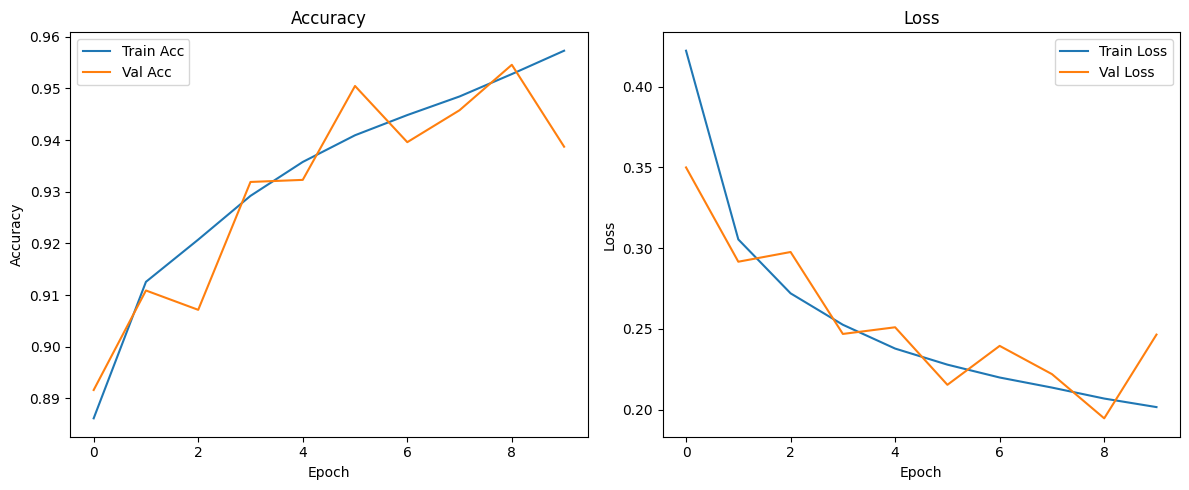

9208/9208 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
5051/5051 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


In [15]:
# Removing DoS
dos_encoding = 6

# --- Get filtered datasets ---
X_classifier_train_no_Dos, y_classifier_train_no_DoS, X_classifier_val_no_DoS, y_classifier_val_no_DoS = Remove_attack_type(dos_encoding)

# --- Get Autoencoder + the per feature thresholds ---
autoencoder, per_feature_thresholds = get_ae()

# --- Get the MLP ---
classifier = build_mlp()

# --- Train the MLP on the new datasets ---
classifier= train_mlp(classifier, X_classifier_train_no_Dos, y_classifier_train_no_DoS, X_classifier_val_no_DoS, y_classifier_val_no_DoS)

# --- Test the models ---
AE_y_pred, classifier_y_preds, classifier_y_test, classifier_x_test = test_models(autoencoder, per_feature_thresholds, classifier, X_test, y_test)


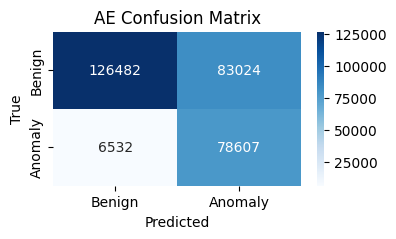


AE Metrics:
True Positives (Anomalies correctly detected): 78607
True Negatives (Normal Traffic correctly identified): 126482
False Positives (Normal Traffic misclassified as Anomaly): 83024
False Negatives (Anomalies missed): 6532

Total number of DoS samples classified as malicious by AE: 35315
Total number of DoS samples classified as benign by AE: 3434


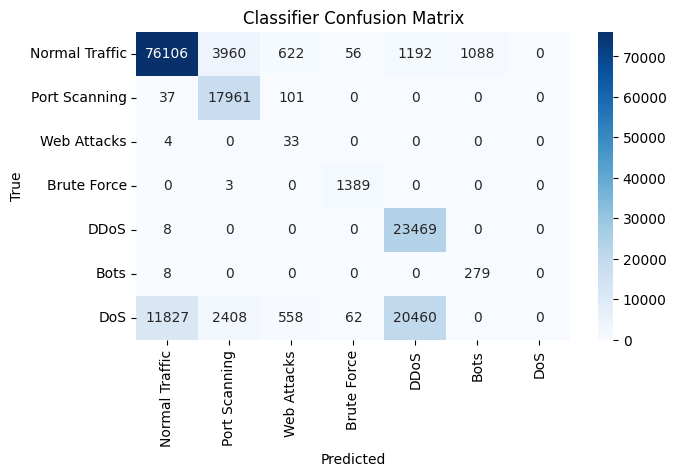


TP, TN, FP, FN for Malware vs Benign (ANY malware type detection):
True Positives (Malware correctly identified): 66723
True Negatives (Benign correctly identified): 76106
False Positives (Benign misclassified as Malware): 6918
False Negatives (Malware missed): 11884

Total number of DoS samples classified as malicious by MLP: 0
Total number of DoS samples classified as benign by MLP: 11827


In [16]:
# --- AE Evaluation ---
evaluate_ae(AE_y_pred, y_test,dos_encoding)


# --- Classifier Evaluation ---
evaluate_classifier(classifier_y_test, classifier_y_preds,dos_encoding)

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


# --- MLP Float32 baseline (no quantization) ---
Saved artifact at '/tmp/tmp1f6tloj5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 52), dtype=tf.float32, name='keras_tensor_55')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  136139221360784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136139221364624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136139221365584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136139221364816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136139221365968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136139221365776: TensorSpec(shape=(), dtype=tf.resource, name=None)
# --- MLP Weight-only quantization (float16 weights, float32 activations) ---
Saved artifact at '/tmp/tmpx07txl88'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 52), dtype=tf.float32, nam

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


# --- MLP Weight-only quantization (int8 weights, float32 activations) ---
Saved artifact at '/tmp/tmp17zx_ic5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 52), dtype=tf.float32, name='keras_tensor_55')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  136139221360784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136139221364624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136139221365584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136139221364816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136139221365968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136139221365776: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


# --- MLP Full 8-bit Integer Quantization ---
Saved artifact at '/tmp/tmpw7lo0c9w'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 52), dtype=tf.float32, name='keras_tensor_55')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  136139221360784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136139221364624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136139221365584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136139221364816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136139221365968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136139221365776: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Quant Models Ready!

 --- Evaluating AE: AE Float32 Model → MLP: MLP Float32 Model ---


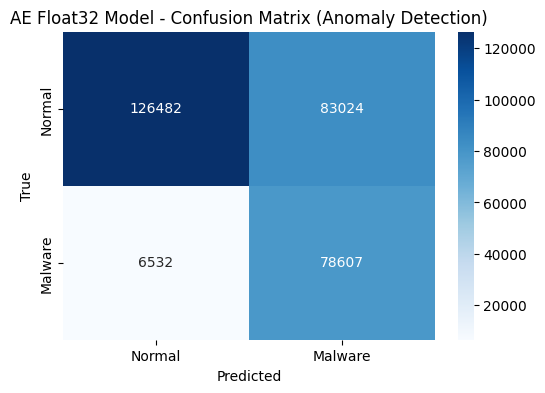


Quant AE Metrics:
True Positives (Anomalies correctly detected): 78607
True Negatives (Normal Traffic correctly identified): 126482
False Positives (Normal Traffic misclassified as Anomaly): 83024
False Negatives (Anomalies missed): 6532

Total number of DoS samples classified as malicious by AE: 35315
Total number of DoS samples classified as benign by AE: 3434


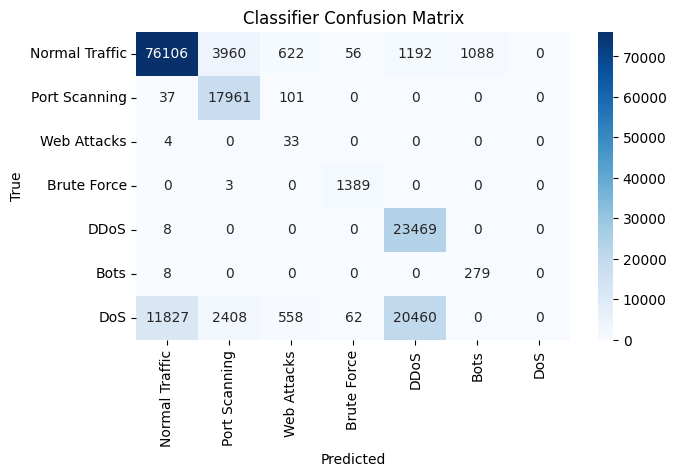


Quant MLP Metrics:
True Positives (Malware correctly identified): 66723
True Negatives (Benign correctly identified): 76106
False Positives (Benign misclassified as Malware): 6918
False Negatives (Malware missed): 11884

Total number of DoS samples classified as malicious by MLP: 0
Total number of DoS samples classified as benign by MLP: 11827

 --- Evaluating AE: AE Float16 Weights-Only Model → MLP: MLP Float16 Weights-Only Model ---


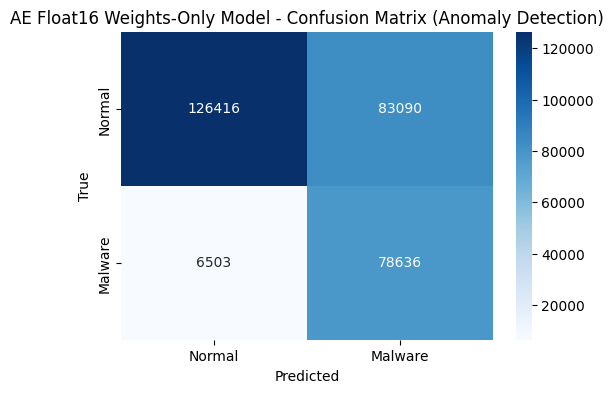


Quant AE Metrics:
True Positives (Anomalies correctly detected): 78636
True Negatives (Normal Traffic correctly identified): 126416
False Positives (Normal Traffic misclassified as Anomaly): 83090
False Negatives (Anomalies missed): 6503

Total number of DoS samples classified as malicious by AE: 35312
Total number of DoS samples classified as benign by AE: 3437


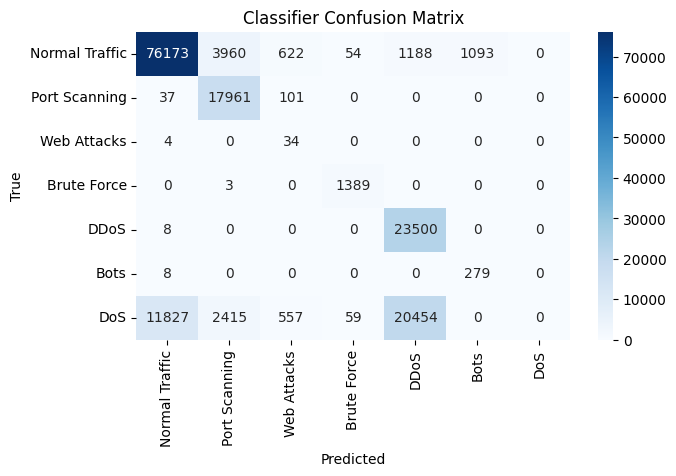


Quant MLP Metrics:
True Positives (Malware correctly identified): 66752
True Negatives (Benign correctly identified): 76173
False Positives (Benign misclassified as Malware): 6917
False Negatives (Malware missed): 11884

Total number of DoS samples classified as malicious by MLP: 0
Total number of DoS samples classified as benign by MLP: 11827

 --- Evaluating AE: AE Int8 Weights-Only Model → MLP: MLP Int8 Weights-Only Model ---


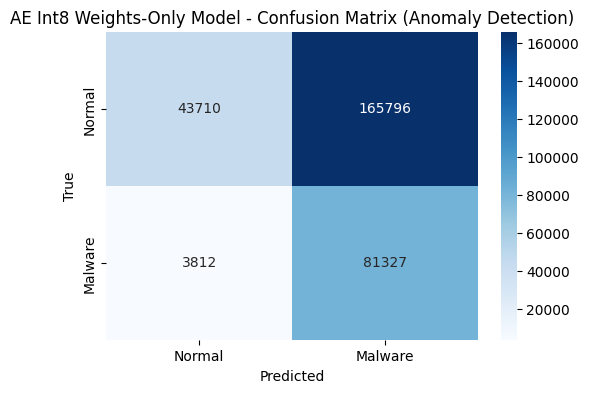


Quant AE Metrics:
True Positives (Anomalies correctly detected): 81327
True Negatives (Normal Traffic correctly identified): 43710
False Positives (Normal Traffic misclassified as Anomaly): 165796
False Negatives (Anomalies missed): 3812

Total number of DoS samples classified as malicious by AE: 36922
Total number of DoS samples classified as benign by AE: 1827


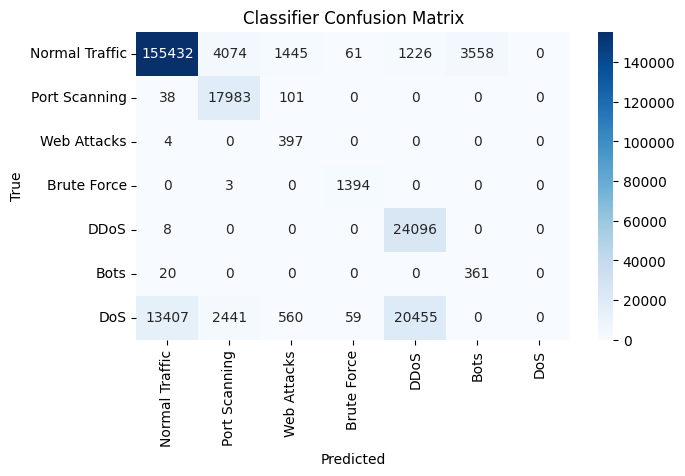


Quant MLP Metrics:
True Positives (Malware correctly identified): 67850
True Negatives (Benign correctly identified): 155432
False Positives (Benign misclassified as Malware): 10364
False Negatives (Malware missed): 13477

Total number of DoS samples classified as malicious by MLP: 0
Total number of DoS samples classified as benign by MLP: 13407

--- Evaluating AE: AE Full Int8 Quantized Model → MLP: MLP Full Int8 Quantized Model ---


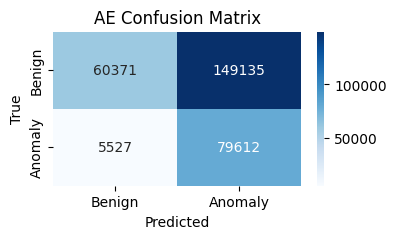


Quant AE Metrics:
True Positives (Anomalies correctly detected): 79612
True Negatives (Normal Traffic correctly identified): 60371
False Positives (Normal Traffic misclassified as Anomaly): 149135
False Negatives (Anomalies missed): 5527

Total number of DoS samples classified as malicious by AE: 36929
Total number of DoS samples classified as benign by AE: 1820


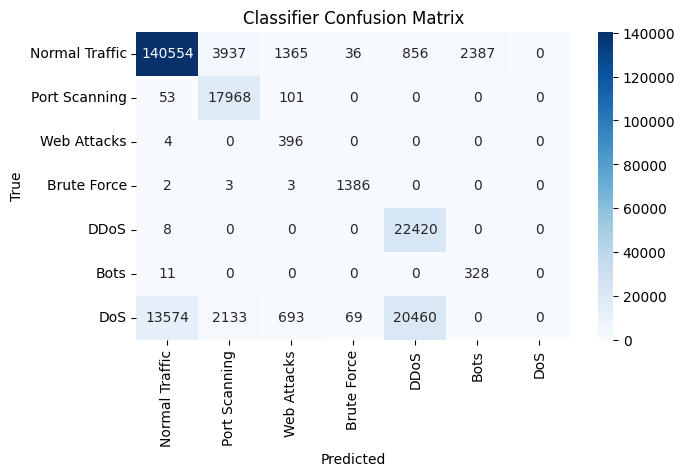


Quant MLP Metrics:
True Positives (Malware correctly identified): 65960
True Negatives (Benign correctly identified): 140554
False Positives (Benign misclassified as Malware): 8581
False Negatives (Malware missed): 13652

Total number of DoS samples classified as malicious by MLP: 0
Total number of DoS samples classified as benign by MLP: 13574


In [17]:
# Evaluate Quant Models
# -----------------------------------
# --- Make Quant Models -------------
# -----------------------------------
ae_quantModel_f32, ae_quantModel_int8_weights, ae_quantModel_fp16_weights, ae_quantModel_full_int8, mlp_quantModel_f32, mlp_quantModel_fp16_weights, mlp_quantModel_int8_weights, mlp_quantModel_full_int8 = quant_models(autoencoder, classifier, y_classifier_train_no_DoS, X_classifier_train_no_Dos)

# List of TFLite models (AE + MLP)
tflite_weight_models = [
    {
        "ae_model": ae_quantModel_f32,
        "ae_name": "AE Float32 Model",
        "mlp_model": mlp_quantModel_f32,
        "mlp_name": "MLP Float32 Model"
    },
    {
        "ae_model": ae_quantModel_fp16_weights,
        "ae_name": "AE Float16 Weights-Only Model",
        "mlp_model": mlp_quantModel_fp16_weights,
        "mlp_name": "MLP Float16 Weights-Only Model"
    },
    {
        "ae_model": ae_quantModel_int8_weights,
        "ae_name": "AE Int8 Weights-Only Model",
        "mlp_model": mlp_quantModel_int8_weights,
        "mlp_name": "MLP Int8 Weights-Only Model"
    }
]
# -----------------------------------
# --- evaluate_weight_quant_model ---
# -----------------------------------
evaluate_weight_quant_model(tflite_weight_models,per_feature_thresholds, dos_encoding)

tflite_full_int_models = [
    {
        "ae_model": ae_quantModel_full_int8,
        "ae_name": "AE Full Int8 Quantized Model",
        "mlp_model": mlp_quantModel_full_int8,
        "mlp_name": "MLP Full Int8 Quantized Model"
    }
]

# --------------------------------------
# --- evaluate_full_int8_quant_model ---
# --------------------------------------
evaluate_full_int8_quant_model(tflite_full_int_models,dos_encoding)


#REMOVING BOTS

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         3,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,703 (22.28 KB)

 Trainable params: 5,703 (22.28 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
27523/27523 ━━━━━━━━━━━━━━━━━━━━ 73s 3ms/step - accuracy: 0.7822 - loss: 0.6976 - val_accuracy: 0.9261 - val_loss: 0.3076
Epoch 2/10
27523/27523 ━━━━━━━━━━━━━━━━━━━━ 78s 2ms/step - accuracy: 0.8522 - loss: 0.4629 - val_accuracy: 0.9216 - val_loss: 0.3025
Epoch 3/10
27523/27523 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - accuracy: 0.8666 - loss: 0.4184 - val_accuracy: 0.9291 - val_loss: 0.2855
Epoch 4/10
27523/27523 ━━━━━━━━━━━━━━━━━━━━ 68s 2ms/step - accuracy: 0.8792 - loss: 0.3919 - val_accuracy: 0.9297 - val_loss: 0.2937
Epoch 5/10
27523/27523 ━━━━━━━━━━━━━━━━━━━━ 83s 2ms/step - accuracy: 0.8967 - loss: 0.3691 - val_accuracy: 0.9440 - val_loss: 0.2703
Epoch 6/10
27523/27523 ━━━━━━━━━━━━━━━━━━━━ 70s 3ms/step - accuracy: 0.9232 - loss: 0.3376 - val_accuracy: 0.9561 - val_loss: 0.2564
Epoch 7/10
27523/27523 ━━━━━━━━━━━━━━━━━━━━ 70s 3ms/step - accuracy: 0.9455 - loss: 0.3049 - val_accuracy: 0.9620 - val_loss: 0.2416
Epoch 8/10
27523/27523 ━━━━━━━━━━━━━━━━━━━━ 70s 3ms/step - accur

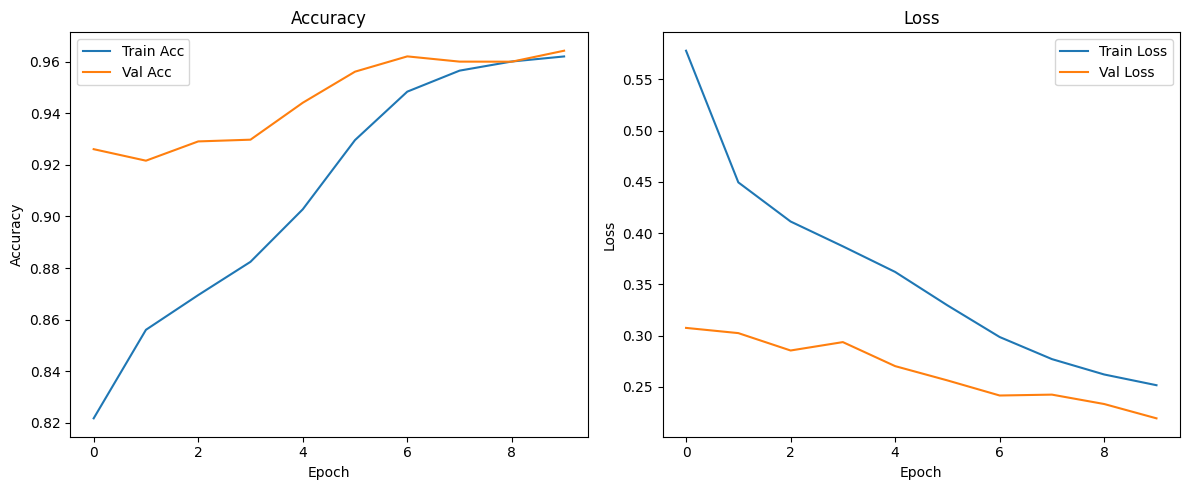

9208/9208 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
5051/5051 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


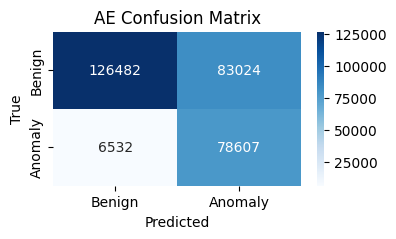


AE Metrics:
True Positives (Anomalies correctly detected): 78607
True Negatives (Normal Traffic correctly identified): 126482
False Positives (Normal Traffic misclassified as Anomaly): 83024
False Negatives (Anomalies missed): 6532

Total number of Bots samples classified as malicious by AE: 287
Total number of Bots samples classified as benign by AE: 102


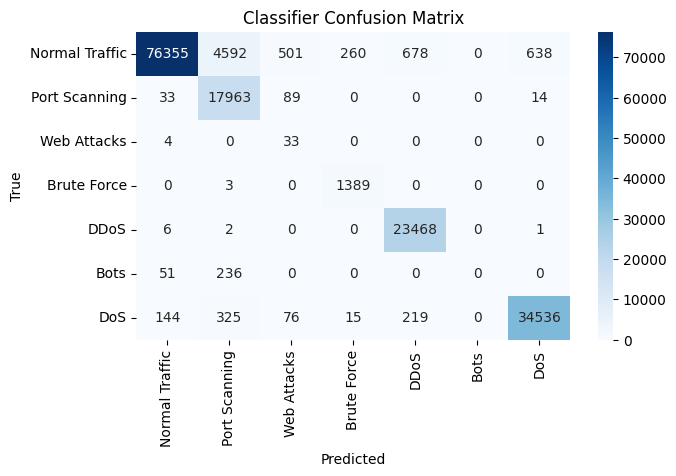


TP, TN, FP, FN for Malware vs Benign (ANY malware type detection):
True Positives (Malware correctly identified): 78369
True Negatives (Benign correctly identified): 76355
False Positives (Benign misclassified as Malware): 6669
False Negatives (Malware missed): 238

Total number of Bots samples classified as malicious by MLP: 0
Total number of Bots samples classified as benign by MLP: 51


In [18]:
# Removing DoS
bots_encoding = 5

# --- Get filtered datasets ---
X_classifier_train_no_Bots, y_classifier_train_no_Bots, X_classifier_val_no_Bots, y_classifier_val_no_Bots = Remove_attack_type(bots_encoding)

# --- Get Autoencoder + the per feature thresholds ---
autoencoder, per_feature_thresholds = get_ae()

# --- Get the MLP ---
classifier = build_mlp()

# --- Train the MLP on the new datasets ---
classifier = train_mlp(classifier, X_classifier_train_no_Bots, y_classifier_train_no_Bots, X_classifier_val_no_Bots, y_classifier_val_no_Bots)

# --- Test the models ---
AE_y_pred, classifier_y_preds, classifier_y_test, classifier_x_test = test_models(autoencoder, per_feature_thresholds, classifier, X_test, y_test)


# --- AE Evaluation ---
evaluate_ae(AE_y_pred, y_test,bots_encoding)


# --- Classifier Evaluation ---
evaluate_classifier(classifier_y_test, classifier_y_preds, bots_encoding)


# --- MLP Float32 baseline (no quantization) ---


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Saved artifact at '/tmp/tmp2_lbw6eg'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 52), dtype=tf.float32, name='keras_tensor_115')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  136140267129744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136140267193936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136140267195280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136140267194512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136140267195664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136140267195472: TensorSpec(shape=(), dtype=tf.resource, name=None)
# --- MLP Weight-only quantization (float16 weights, float32 activations) ---
Saved artifact at '/tmp/tmp2hwo2aem'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 52), dtype=tf.float32, name='keras_tensor_115')
Output Type:
  TensorSpec(

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


# --- MLP Weight-only quantization (int8 weights, float32 activations) ---
Saved artifact at '/tmp/tmpkb2p2i6r'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 52), dtype=tf.float32, name='keras_tensor_115')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  136140267129744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136140267193936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136140267195280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136140267194512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136140267195664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136140267195472: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


# --- MLP Full 8-bit Integer Quantization ---
Saved artifact at '/tmp/tmpir0siwmm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 52), dtype=tf.float32, name='keras_tensor_115')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  136140267129744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136140267193936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136140267195280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136140267194512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136140267195664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136140267195472: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Quant Models Ready!

 --- Evaluating AE: AE Float32 Model → MLP: MLP Float32 Model ---


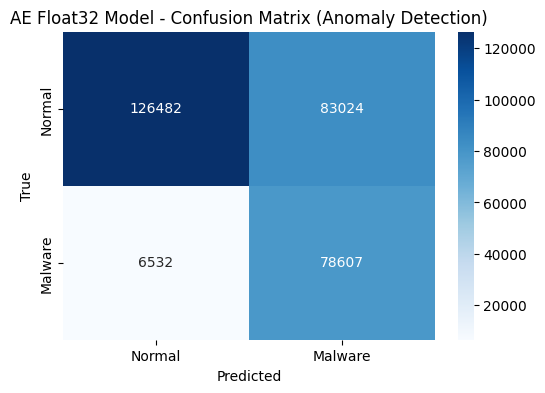


Quant AE Metrics:
True Positives (Anomalies correctly detected): 78607
True Negatives (Normal Traffic correctly identified): 126482
False Positives (Normal Traffic misclassified as Anomaly): 83024
False Negatives (Anomalies missed): 6532

Total number of Bots samples classified as malicious by AE: 287
Total number of Bots samples classified as benign by AE: 102


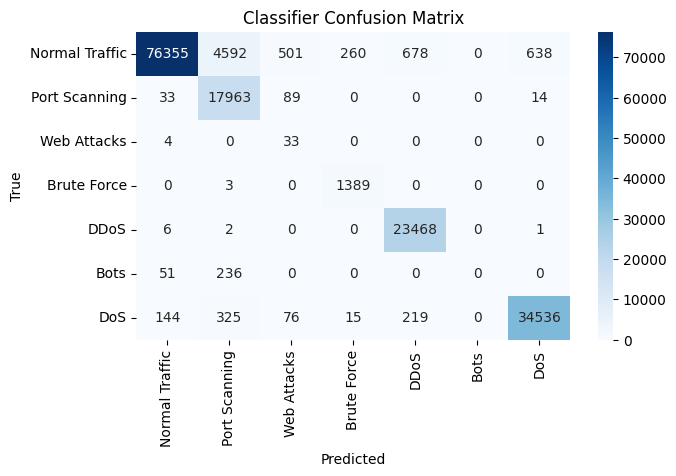


Quant MLP Metrics:
True Positives (Malware correctly identified): 78369
True Negatives (Benign correctly identified): 76355
False Positives (Benign misclassified as Malware): 6669
False Negatives (Malware missed): 238

Total number of Bots samples classified as malicious by MLP: 0
Total number of Bots samples classified as benign by MLP: 51

 --- Evaluating AE: AE Float16 Weights-Only Model → MLP: MLP Float16 Weights-Only Model ---


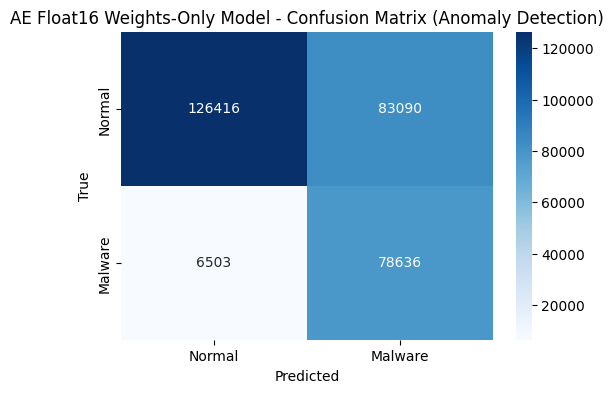


Quant AE Metrics:
True Positives (Anomalies correctly detected): 78636
True Negatives (Normal Traffic correctly identified): 126416
False Positives (Normal Traffic misclassified as Anomaly): 83090
False Negatives (Anomalies missed): 6503

Total number of Bots samples classified as malicious by AE: 287
Total number of Bots samples classified as benign by AE: 102


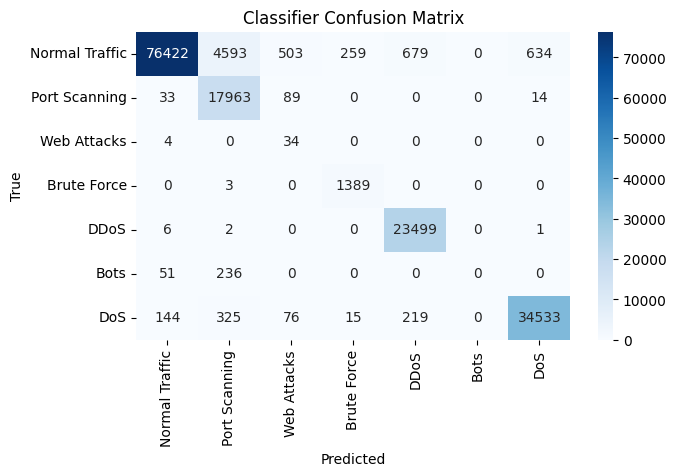


Quant MLP Metrics:
True Positives (Malware correctly identified): 78398
True Negatives (Benign correctly identified): 76422
False Positives (Benign misclassified as Malware): 6668
False Negatives (Malware missed): 238

Total number of Bots samples classified as malicious by MLP: 0
Total number of Bots samples classified as benign by MLP: 51

 --- Evaluating AE: AE Int8 Weights-Only Model → MLP: MLP Int8 Weights-Only Model ---


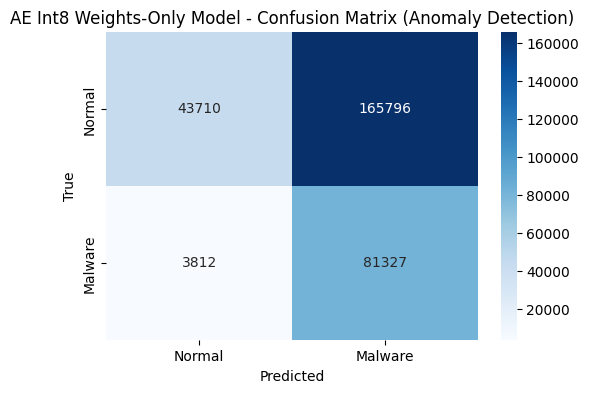


Quant AE Metrics:
True Positives (Anomalies correctly detected): 81327
True Negatives (Normal Traffic correctly identified): 43710
False Positives (Normal Traffic misclassified as Anomaly): 165796
False Negatives (Anomalies missed): 3812

Total number of Bots samples classified as malicious by AE: 381
Total number of Bots samples classified as benign by AE: 8


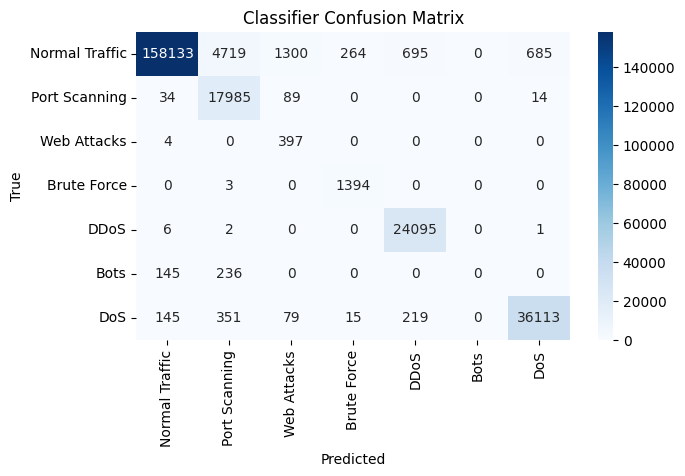


Quant MLP Metrics:
True Positives (Malware correctly identified): 80993
True Negatives (Benign correctly identified): 158133
False Positives (Benign misclassified as Malware): 7663
False Negatives (Malware missed): 334

Total number of Bots samples classified as malicious by MLP: 0
Total number of Bots samples classified as benign by MLP: 145

--- Evaluating AE: AE Full Int8 Quantized Model → MLP: MLP Full Int8 Quantized Model ---


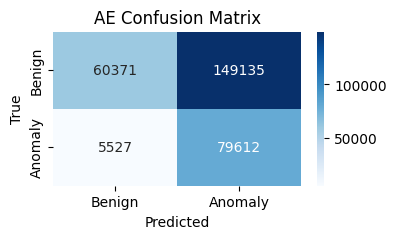


Quant AE Metrics:
True Positives (Anomalies correctly detected): 79612
True Negatives (Normal Traffic correctly identified): 60371
False Positives (Normal Traffic misclassified as Anomaly): 149135
False Negatives (Anomalies missed): 5527

Total number of Bots samples classified as malicious by AE: 339
Total number of Bots samples classified as benign by AE: 50


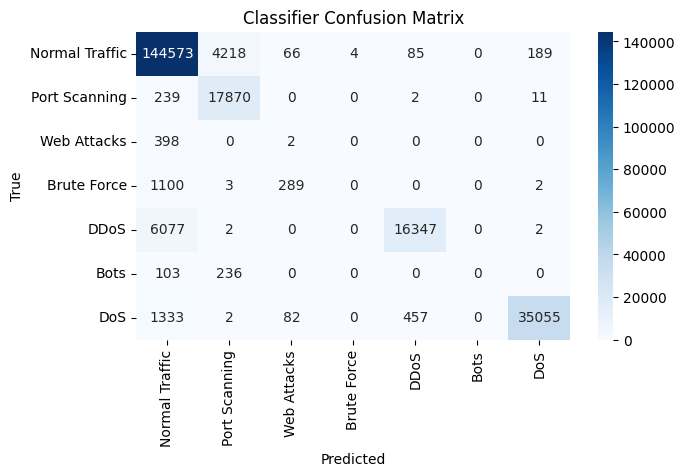


Quant MLP Metrics:
True Positives (Malware correctly identified): 70362
True Negatives (Benign correctly identified): 144573
False Positives (Benign misclassified as Malware): 4562
False Negatives (Malware missed): 9250

Total number of Bots samples classified as malicious by MLP: 0
Total number of Bots samples classified as benign by MLP: 103


In [19]:
# Evaluate Quant Models
# -----------------------------------
# --- Make Quant Models -------------
# -----------------------------------
ae_quantModel_f32, ae_quantModel_int8_weights, ae_quantModel_fp16_weights, ae_quantModel_full_int8, mlp_quantModel_f32, mlp_quantModel_fp16_weights, mlp_quantModel_int8_weights, mlp_quantModel_full_int8 = quant_models(autoencoder, classifier, y_classifier_train_no_Bots, X_classifier_train_no_Bots)

# List of TFLite models (AE + MLP)
tflite_weight_models = [
    {
        "ae_model": ae_quantModel_f32,
        "ae_name": "AE Float32 Model",
        "mlp_model": mlp_quantModel_f32,
        "mlp_name": "MLP Float32 Model"
    },
    {
        "ae_model": ae_quantModel_fp16_weights,
        "ae_name": "AE Float16 Weights-Only Model",
        "mlp_model": mlp_quantModel_fp16_weights,
        "mlp_name": "MLP Float16 Weights-Only Model"
    },
    {
        "ae_model": ae_quantModel_int8_weights,
        "ae_name": "AE Int8 Weights-Only Model",
        "mlp_model": mlp_quantModel_int8_weights,
        "mlp_name": "MLP Int8 Weights-Only Model"
    }
]
# -----------------------------------
# --- evaluate_weight_quant_model ---
# -----------------------------------
evaluate_weight_quant_model(tflite_weight_models,per_feature_thresholds, bots_encoding)

tflite_full_int_models = [
    {
        "ae_model": ae_quantModel_full_int8,
        "ae_name": "AE Full Int8 Quantized Model",
        "mlp_model": mlp_quantModel_full_int8,
        "mlp_name": "MLP Full Int8 Quantized Model"
    }
]

# --------------------------------------
# --- evaluate_full_int8_quant_model ---
# --------------------------------------
evaluate_full_int8_quant_model(tflite_full_int_models,bots_encoding)
